<a href="https://colab.research.google.com/github/DHKing7/dahyunk/blob/main/faster_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.3 MB 24 kB/s 
     |████████████████████████████████| 12.7 MB 55.8 MB/s 
     |████████████████████████████████| 7.6 MB 25.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torc

In [ ]:
cd drive/MyDrive/캡스톤디자인/2. filled

/content/drive/MyDrive/캡스톤디자인/2. filled


In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')
  print('There are %d GPU(s) available.' %torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
  print('No GPU available, using the CPU instead.')
  device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('Images/Images')))
print(len(os.listdir('Annotations')))

# !mkdir test_images
# !mkdir test_annotations


539
539


In [ ]:
# random.seed(1234)
# idx = random.sample(range(674), 135)

# for img in np.array(sorted(os.listdir('Images/Images')))[idx]:
#   shutil.move('Images/Images/'+img, 'test_images/'+img)

# for annot in np.array(sorted(os.listdir('Annotations')))[idx]:
#   shutil.move('Annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('Images/Images')))
print(len(os.listdir('Annotations')))
print(len(os.listdir('test_images')))
print(len(os.listdir('test_annotations')))

539
539
135
135


In [ ]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time
import json

In [ ]:
def generate_box(obj):
    
    xmin = obj['bbox'][0]
    ymin = obj['bbox'][1]
    xmax = obj['bbox'][0]+obj['bbox'][2]
    ymax = obj['bbox'][1]+obj['bbox'][3]
    
    return [xmin, ymin, xmax, ymax]

adjust_label = 1

def generate_label(obj):

    if obj['category_id'] == 7: 
        return 7 + adjust_label

    elif obj['category_id'] == 8: 
        return 8 + adjust_label

    elif obj['category_id'] == 9:
      return 9 + adjust_label
    return 0 + adjust_label


def generate_target(file): 
    with open(f'{file}') as f:
        data = json.load(f)

        boxes = []
        labels = []
        for i in data['annotations']:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output1(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 7 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 8 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
        
        elif annotation['labels'][idx] == 9 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()



class MaskDataset(object):

  def __init__(self, transforms, path):
    self.transforms = transforms
    self.path = path
    self.imgs = list(sorted(os.listdir(self.path)))
    

  def __getitem__(self, idx):
    file_image = self.imgs[idx]
    file_label = self.imgs[idx][:-4] +'_BBOX.json'
    img_path = os.path.join(self.path, file_image)

    if 'test' in self.path:
      label_path = os.path.join('test_annotations/', file_label)
    else:
      label_path = os.path.join('Annotations/', file_label)

    img = Image.open(img_path).convert('RGB')
    target = generate_target(label_path)

    if self.transforms is not None:
      img = self.transforms(img)

    return img, target

  def __len__(self):
    return len(self.imgs)

data_transform = transforms.Compose([
       transforms.ToTensor()
    ])

def collate_fn(batch):
  return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'Images/Images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size = 4, collate_fn = collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, collate_fn = collate_fn)

In [ ]:
def get_model_instance_segmentation(num_classes):

  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [ ]:
model = get_model_instance_segmentation(11)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

NameError: ignored

In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.005)

In [ ]:
print('________________train start___________________')
for epoch in range(num_epochs):
  start = time.time()
  model.train()
  i = 0
  epoch_loss = 0
  for imgs, annotations in data_loader:
    i+=1
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for  k, v in t.items()} for t in annotations]
    loss_dict = model(imgs, annotations)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    epoch_loss += losses
  
  print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time()-start}')

________________train start___________________
epoch : 1, Loss : 66.06609344482422, time : 235.25235223770142
epoch : 2, Loss : 44.6011962890625, time : 151.83331489562988
epoch : 3, Loss : 38.05587387084961, time : 152.88458061218262
epoch : 4, Loss : 34.2373046875, time : 154.50998997688293
epoch : 5, Loss : 32.101898193359375, time : 154.516907453537
epoch : 6, Loss : 31.66385841369629, time : 154.4822118282318
epoch : 7, Loss : 29.51517105102539, time : 156.0175588130951
epoch : 8, Loss : 28.93820571899414, time : 153.91376638412476
epoch : 9, Loss : 29.240690231323242, time : 153.59665036201477
epoch : 10, Loss : 29.38908576965332, time : 153.64952516555786


In [ ]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

NameError: ignored

In [ ]:
def make_prediction(model, img, threshold):
  model.eval()
  preds = model(img)
  for id in range(len(preds)):
    idx_list = []

    for idx, score in enumerate(preds[id]['scores']):
      if score > threshold:
        idx_list.append(idx)

    preds[id]['boxes'] = preds[id]['boxes'][idx_list].cpu()
    preds[id]['labels'] = preds[id]['labels'][idx_list]
    preds[id]['scores'] = preds[id]['scores'][idx_list]

  return preds

In [ ]:
with torch.no_grad():

  for imgs, annotations in test_data_loader:
    imgs = list(img.to(device) for img in imgs)

    pred = make_prediction(model, imgs, 0.5)
    pred = pred
    print(pred)
    break
  

[{'boxes': tensor([[670.0225, 439.6854, 766.3001, 496.3856],
        [767.3671,   5.6821, 841.8846, 100.4684],
        [580.6780, 287.8899, 697.2532, 307.3075],
        [796.7575, 221.7943, 831.8474, 232.5668],
        [727.6397, 357.3130, 845.5058, 401.6957],
        [668.9047, 444.3695, 757.3898, 475.4886],
        [644.1094, 304.2846, 703.8249, 320.9150]]), 'labels': tensor([10,  1, 10, 10, 10, 10, 10], device='cuda:0'), 'scores': tensor([0.9669, 0.8955, 0.8626, 0.7330, 0.6705, 0.6532, 0.5278],
       device='cuda:0')}, {'boxes': tensor([[ 488.7026,  312.8486,  590.6061,  339.5362],
        [  25.8819,  244.2853,  376.4384,  324.6721],
        [ 983.4721,  336.2134, 1174.5277,  421.4052],
        [ 516.0820,  312.9818,  588.3036,  331.2959],
        [ 438.5384,  433.3062,  524.8867,  455.0924]]), 'labels': tensor([10, 10, 10, 10, 10], device='cuda:0'), 'scores': tensor([0.9864, 0.9254, 0.8202, 0.6061, 0.5744], device='cuda:0')}]


Target :  tensor([10])


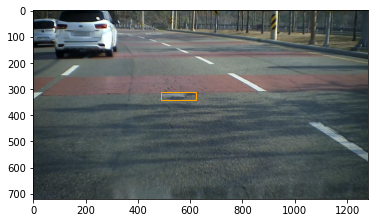

Prediction :  tensor([10, 10, 10, 10, 10], device='cuda:0')


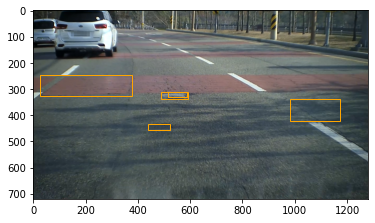

In [ ]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output1(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output1(imgs[_idx], pred[_idx])

In [ ]:
print(pred[_idx]['boxes'].to('cpu'))

tensor([[ 488.7026,  312.8486,  590.6061,  339.5362],
        [  25.8819,  244.2853,  376.4384,  324.6721],
        [ 983.4721,  336.2134, 1174.5277,  421.4052],
        [ 516.0820,  312.9818,  588.3036,  331.2959],
        [ 438.5384,  433.3062,  524.8867,  455.0924]])


In [ ]:
print(annotations[_idx])

{'boxes': tensor([[487.5000, 310.5000, 621.5000, 342.5000]]), 'labels': tensor([10])}


In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im,annot in tqdm(test_data_loader, position = 0, leave = True):
  im = list(img.to(device) for img in im)

  for t in annot:
    labels += t['labels']

  with torch.no_grad():
    preds_adj = make_prediction(model, im, 0.5)
    preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
    preds_adj_all.append(preds_adj)
    annot_all.append(annot)

100%|██████████| 68/68 [01:28<00:00,  1.30s/it]


In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 30 (delta 9), reused 18 (delta 5), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [ ]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/drive/MyDrive/캡스톤디자인/2. filled/Tutorial-Book-Utils


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
  sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.5448311458891988
AP : tensor([0.5968, 0.4928], dtype=torch.float64)
